In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc',
    'geopotential_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc',
    'mslp_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',    
    'humidity_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022400_2019022423.nc',
    'v_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022400_2019022423.nc',
    'u_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022400_2019022423.nc',
    'u_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc'
}

# Load the datasets from the URLs
datasets = {}
for var, url in urls.items():
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    datasets[var] = ds

# Merge all pressure level datasets into a single Xarray Dataset
ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl']])

# Merge all surface datasets into a single Xarray Dataset
ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,
C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g

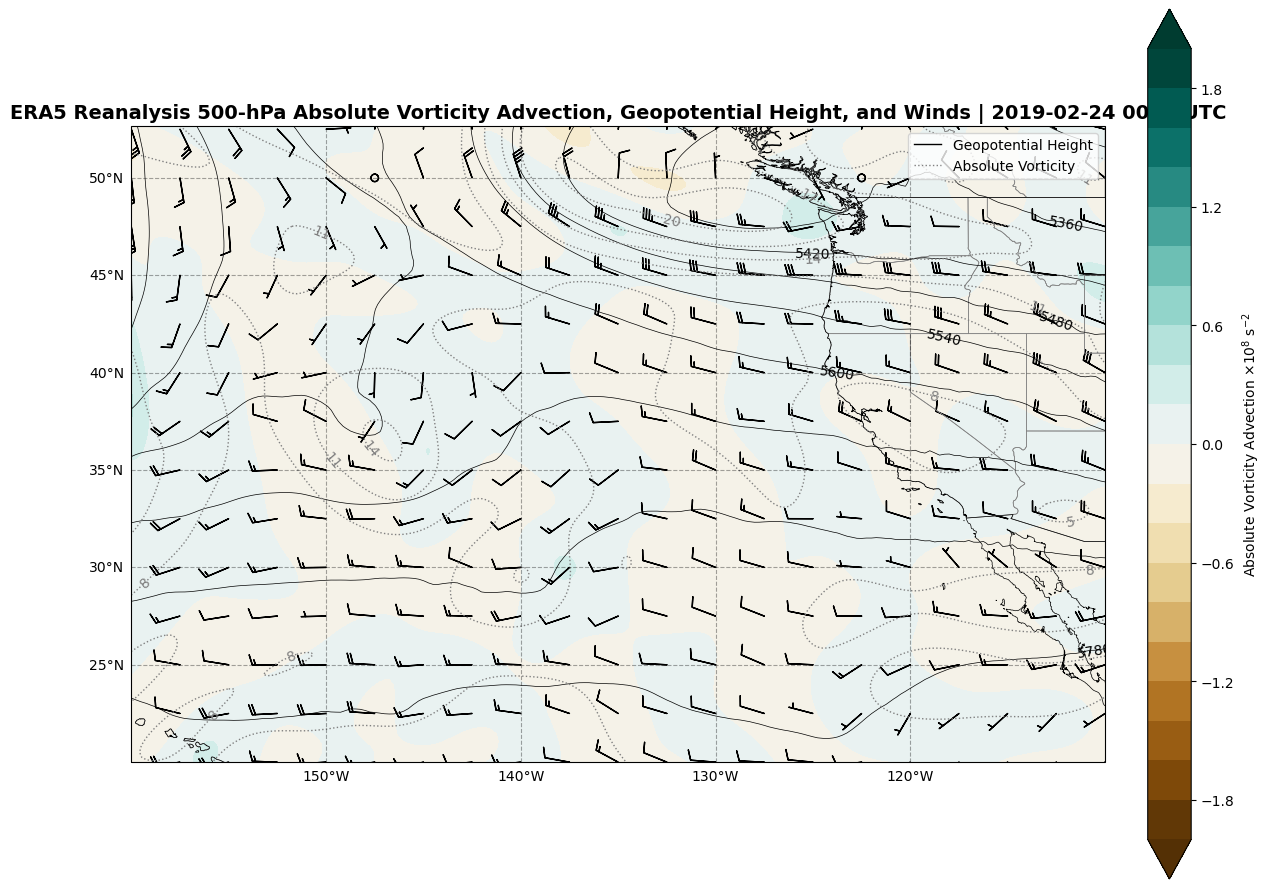

In [46]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None, ax=None, threshold=0.5):
    from scipy.ndimage import maximum_filter, minimum_filter
    import numpy as np

    if ax is None:
        ax = plt.gca()

    if extrema == 'max':
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif extrema == 'min':
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for extrema must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    # To keep track of unique points
    plotted_points = []

    for i in range(len(mxy)):
        lon_coord = lon[mxx[i]].item()
        lat_coord = lat[mxy[i]].item()
        
        # Check distance from already plotted points
        if not any(np.sqrt((lon_coord - lon_p)**2 + (lat_coord - lat_p)**2) < threshold for lon_p, lat_p in plotted_points):
            ax.text(lon_coord, lat_coord, symbol, color=color, size=24,
                    clip_on=True, clip_box=ax.bbox, horizontalalignment='center', 
                    verticalalignment='center', transform=transform)
            ax.text(lon_coord, lat_coord, 
                    '\n' + str(int(data[mxy[i], mxx[i]])), 
                    color=color, size=12, clip_on=True, clip_box=ax.bbox, 
                    fontweight='bold', horizontalalignment='center', 
                    verticalalignment='top', transform=transform)

            # Mark this point as plotted
            plotted_points.append((lon_coord, lat_coord))

def plot_250_isotachs_mslp(ds_pl, ds_sfc, directions):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_pl_sliced['U'].sel(level=250) # units: m/s
        v_250 = ds_pl_sliced['V'].sel(level=250) # units: m/s
        z_250 = ds_pl_sliced['Z'].sel(level=250) / g # units: m
        pressure_levels = u_250.level * 100 # units: Pa

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Get the lats and lons
        lats = mslp['latitude'][:]
        lons = mslp['longitude'][:] 
        
        # Smooth the mslp and wind speed
        mslp_smoothed = gaussian_filter(mslp, sigma=3)
        wnd_smoothed = gaussian_filter(wind_speed_250, sigma=3)

        # Define the color levels and colors for the isotachs
        levels = np.arange(20, 95, 5)
        colors = ['#daedfb', '#b7dcf6', '#91bae4', '#7099ce', '#6a999d', '#72ad63', '#77c14a', '#cad955', '#f8cf4f', '#f7953c', '#ef5f28', '#e13e26', '#cd1e28', '#b1181e', '#901617']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        c = plt.contour(mslp['longitude'], mslp['latitude'], mslp_smoothed, colors='black', levels=np.arange(960, 1080, 4), linewidths=0.5)
        ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        #c = plt.contour(u_250['longitude'], u_250['latitude'], wnd_smoothed, colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], wnd_smoothed, cmap=cmap, norm=norm, levels=levels, extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (ms$^{-1}$)', fraction=0.046, pad=0.04)

        # Pass ax to plot_maxmin_points
        plot_maxmin_points(lons, lats, mslp_smoothed, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        plot_maxmin_points(lons, lats, mslp_smoothed, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        #step = 5
        #ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs and MSLP | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North'] - 5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        plt.show()

def plot_ivt_hl(g, ds_pl, ds_sfc, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg

        # Flip the order of the pressure levels and convert them to Pa from hPa
        pressure_levels = u_sliced.level[::-1] * 100 # units: Pa

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa
        
        # Get the lats and lons
        lats = mslp['latitude'][:]
        lons = mslp['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the IVT
        c = plt.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='IVT (kg/m/s)', fraction=0.046, pad=0.04)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        
        plot_maxmin_points(lons, lats, mslp, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        plot_maxmin_points(lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Integrated Water Vapor Transport (IVT) | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()


def plot_q_uv_zeta(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=850) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=850) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=850) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=850) * 1000 # units: g/kg

        # Calculate the potential temperature and relative vorticity
        theta_sliced = mpcalc.potential_temperature(850 * units.hPa, t_sliced) # units: K
        zeta_sliced = mpcalc.vorticity(u_sliced, v_sliced) # units: 10^-5 s^-1

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Define the color levels and colors for the specific humidity
        levels = np.arange(4, 15, 1)
        colors = ['#c3e8fa', '#8bc5e9', '#5195cf', '#49a283', '#6cc04b', '#d8de5a', '#f8b348', '#f46328', '#dc352b', '#bb1b24', '#911618']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the specific humidity and potential temperature
        q_smoothed = gaussian_filter(q_sliced, sigma=1)
        theta_smoothed = gaussian_filter(theta_sliced, sigma=1)
        zeta_smoothed = gaussian_filter(zeta_sliced, sigma=1)

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the specific humidity, potential temperature, and wind barbs
        plt.contour(zeta_sliced['longitude'], zeta_sliced['latitude'], zeta_smoothed, colors='purple', levels=np.arange(10 * 10**-5, 30 * 10**-5, 10**-5), linewidths=0.5, label='$\\zeta$')
        plt.contour(theta_sliced['longitude'], theta_sliced['latitude'], theta_smoothed, colors='black', levels=np.arange(220, 340, 1), linewidths=0.5, label='$\\theta$')
        cf = plt.contourf(q_sliced['longitude'], q_sliced['latitude'], q_smoothed, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='Specific Humidity (g kg$^{-1}$)', fraction=0.046, pad=0.04)

        # Plot the 850-hPa wind barbs
        step = 10
        ax.barbs(u_sliced['longitude'][::step], u_sliced['latitude'][::step], u_sliced[::step, ::step], v_sliced[::step, ::step], length=6, color='black')

        # Adding custom legend entries (hardcoded)
        zeta_line = plt.Line2D([0], [0], color='purple', linewidth=1, label=r'$\zeta$ Relative Vorticity')
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature')

        # Creating the legend with the custom entries
        ax.legend(handles=[zeta_line, theta_line], loc='upper right')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 850-hPa Specific Humidity, $\\theta$, $\\zeta$, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_fgen(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=850) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=850) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=850) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=850) * 1000 # units: g/kg

        # Calculate the potential temperature and relative vorticity
        theta_sliced = mpcalc.potential_temperature(850 * units.hPa, t_sliced) # units: K
        
        # Calculate the frontogenesis 
        fgen = mpcalc.frontogenesis(theta_sliced, u_sliced, v_sliced)
        convert_to_per_100km_3h = 1000*100*3600*3

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Define the color levels and colors for the specific humidity
        #levels = np.arange(4, 15, 1)
        #colors = ['#c3e8fa', '#8bc5e9', '#5195cf', '#49a283', '#6cc04b', '#d8de5a', '#f8b348', '#f46328', '#dc352b', '#bb1b24', '#911618']
        #cmap = mcolors.ListedColormap(colors)
        #norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the specific humidity and potential temperature
        q_smoothed = gaussian_filter(q_sliced, sigma=1)
        theta_smoothed = gaussian_filter(theta_sliced, sigma=1)
        fgen_smoothed = gaussian_filter(fgen, sigma=1)
        #zeta_smoothed = gaussian_filter(zeta_sliced, sigma=1)

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the specific humidity, potential temperature, and wind barbs
        #plt.contour(zeta_sliced['longitude'], zeta_sliced['latitude'], zeta_smoothed, colors='purple', levels=np.arange(10 * 10**-5, 30 * 10**-5, 10**-5), linewidths=0.5, label='$\\zeta$')
        plt.contour(theta_sliced['longitude'], theta_sliced['latitude'], theta_smoothed, colors='black', levels=np.arange(220, 340, 1), linewidths=0.5, label='$\\theta$')
        cf = plt.contourf(fgen['longitude'], fgen['latitude'], fgen_smoothed*convert_to_per_100km_3h, cmap=plt.cm.bwr, levels=np.arange(-8, 8.5, 0.5), extend='max')
        #plt.colorbar(cf, orientation='vertical', label='Specific Humidity (g kg$^{-1}$)', fraction=0.046, pad=0.04)

        # Plot the 850-hPa wind barbs
        step = 10
        X, Y = np.meshgrid(u_sliced['longitude'][::step], u_sliced['latitude'][::step])

        # Plotting the streamlines
        ax.streamplot(X, Y, u_sliced[::step, ::step], v_sliced[::step, ::step], color='black')

        # Adding custom legend entries (hardcoded)
        #zeta_line = plt.Line2D([0], [0], color='purple', linewidth=1, label=r'$\zeta$ Relative Vorticity')
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature')

        # Creating the legend with the custom entries
        #ax.legend(handles=[zeta_line, theta_line], loc='upper right')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 850-hPa Specific Humidity, $\\theta$, $\\zeta$, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_qvec_700(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=700) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=700) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=700) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=700) * 1000 # units: g/kg

        # Calculate Q-vector 
        u_qvec, v_qvec = mpcalc.q_vector(u_sliced, v_sliced, t_sliced, 700 * units.hPa)

        # Calculate the temperature advection
        tadv = mpcalc.advection(t_sliced, u_sliced, v_sliced) # units K/s

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Define the color levels and colors for the specific humidity
        #levels = np.arange(4, 15, 1)
        #colors = ['#c3e8fa', '#8bc5e9', '#5195cf', '#49a283', '#6cc04b', '#d8de5a', '#f8b348', '#f46328', '#dc352b', '#bb1b24', '#911618']
        #cmap = mcolors.ListedColormap(colors)
        #norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the specific humidity and potential temperature
        q_smoothed = gaussian_filter(q_sliced, sigma=1)
        #zeta_smoothed = gaussian_filter(zeta_sliced, sigma=1)

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the specific humidity, potential temperature, and wind barbs
        #plt.contour(zeta_sliced['longitude'], zeta_sliced['latitude'], zeta_smoothed, colors='purple', levels=np.arange(10 * 10**-5, 30 * 10**-5, 10**-5), linewidths=0.5, label='$\\zeta$')
        #plt.contour(theta_sliced['longitude'], theta_sliced['latitude'], theta_smoothed, colors='black', levels=np.arange(220, 340, 1), linewidths=0.5, label='$\\theta$')
        #cf = plt.contourf(fgen['longitude'], fgen['latitude'], fgen_smoothed*convert_to_per_100km_3h, cmap=plt.cm.bwr, levels=np.arange(-8, 8.5, 0.5), extend='max')
        #plt.colorbar(cf, orientation='vertical', label='Specific Humidity (g kg$^{-1}$)', fraction=0.046, pad=0.04)

        cf = plt.contourf(tadv['longitude'], tadv['latitude'], tadv.metpy.convert_units('kelvin/hour') * 3, cmap=plt.cm.bwr, levels=np.arange(-6, 7, 1), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Specific Humidity (g kg$^{-1}$)', fraction=0.046, pad=0.04)

        # Plot the 850-hPa wind barbs
        step = 10
        #qvec = ax.quiver(ds.longitude.values[::step], ds.latitude.values[::step],
        #                u_qvec[::step, ::step] * 1e13, v_qvec[::step, ::step] * 1e13,
         #               color='black', scale=1000, alpha=0.5, width=0.01)
        
        qvec =  plt.quiver(u_qvec['longitude'][::step], u_qvec['latitude'][::step], u_qvec[::step, ::step]* 1e14, v_qvec[::step, ::step]* 1e14, scale=250,scale_units='xy', color='black')


        qk = ax.quiverkey(qvec, 0.8, 0.9, 200, r'$200 m^2/kg/s$', labelpos='E',
                        coordinates='figure')

        # Adding custom legend entries (hardcoded)
        #zeta_line = plt.Line2D([0], [0], color='purple', linewidth=1, label=r'$\zeta$ Relative Vorticity')
        #theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature')

        # Creating the legend with the custom entries
        #ax.legend(handles=[zeta_line, theta_line], loc='upper right')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 850-hPa Specific Humidity, $\\theta$, $\\zeta$, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def calc_qg(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 700)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 700)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 700)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 700)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=700) * 1000 # units: g/kg

        # Selecting
        z_500 = z_sliced.sel(level=500)
        z_700 = z_sliced.sel(level=700)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_700, v_g_700 = mpcalc.geostrophic_wind(z_700) * units.meter / units.second
        V_g_700 = mpcalc.wind_speed(u_g_700, v_g_700)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u_sliced, v_sliced)
        absolute_vorticity_700 = absolute_vorticity.sel(level=700)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)

        # Calculate the gradient of absolute vorticity at 500 hPa and 700 hPa
        grad_vorticity_500_lat = absolute_vorticity_500.differentiate('latitude')
        grad_vorticity_500_lon = absolute_vorticity_500.differentiate('longitude')

        grad_vorticity_700_lat = absolute_vorticity_700.differentiate('latitude')
        grad_vorticity_700_lon = absolute_vorticity_700.differentiate('longitude')

        # Compute vorticity advection at 500 hPa
        vorticity_advection_500 = -(u_g_500 * grad_vorticity_500_lon + v_g_500 * grad_vorticity_500_lat)

        # Compute vorticity advection at 700 hPa
        vorticity_advection_700 = -(u_g_700 * grad_vorticity_700_lon + v_g_700 * grad_vorticity_700_lat)

        # Calculate differential vorticity advection
        differential_vorticity_advection = vorticity_advection_500 - vorticity_advection_700

        # Smoothing the differential vorticity advection
        differential_vorticity_advection_smoothed = gaussian_filter(differential_vorticity_advection, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6000, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(differential_vorticity_advection['longitude'], differential_vorticity_advection['latitude'], differential_vorticity_advection_smoothed, cmap=plt.cm.bwr, extend='max')
        plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def calc_qg_omega_term_a(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Selecting
        z_500 = z_sliced.sel(level=500)
        z_900 = z_sliced.sel(level=900)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
        V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u_sliced, v_sliced)
        absolute_vorticity_900 = absolute_vorticity.sel(level=900)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)

        # Calculate the gradient of absolute vorticity at 500 hPa and 700 hPa
        grad_vorticity_500_lat = absolute_vorticity_500.differentiate('latitude')
        grad_vorticity_500_lon = absolute_vorticity_500.differentiate('longitude')

        grad_vorticity_900_lat = absolute_vorticity_900.differentiate('latitude')
        grad_vorticity_900_lon = absolute_vorticity_900.differentiate('longitude')

        abs_vort_adv = mpcalc.advection(absolute_vorticity, u_sliced, v_sliced)

        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        abs_vort_adv_900 = abs_vort_adv.sel(level=900)

        # Define constants 
        f_0 = 1 * 10**-4 * units('s^-1') # Coriolis parameter
        sigma = 2 * 10**-6 * units('m^2*Pa^-2*s^-2') # Static stability

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Calculate the omega term A
        omega_term_a = (-(f_0 / sigma) * differential_abs_vorticity_advection)

        # Smoothing the differential vorticity advection
        omega_term_a_smoothed = gaussian_filter(omega_term_a, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)
        z_900_smoothed = gaussian_filter(z_900, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(omega_term_a['longitude'], omega_term_a['latitude'], omega_term_a_smoothed * 10e12, levels=np.arange(-20, 20, 1), cmap=plt.cm.RdYlBu_r, extend='both')
        plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def calc_qg_omega_term_a_smoothed(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+10, directions['South']-10), longitude=slice(directions['West']-10, directions['East']+10))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Selecting
        z_500 = z_sliced.sel(level=500)
        z_900 = z_sliced.sel(level=900)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
        V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)

        # MetPy smoothing
        n_reps = 80
        z_500_s = mpcalc.smooth_n_point(z_500, 9, n_reps)
        z_900_s = mpcalc.smooth_n_point(z_900, 9, n_reps)
        u_s = mpcalc.smooth_n_point(u_sliced, 9, n_reps)
        v_s = mpcalc.smooth_n_point(v_sliced, 9, n_reps)


        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u_s, v_s)
        absolute_vorticity_900 = absolute_vorticity.sel(level=900)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)

        # Calculate the absolute vorticity advection
        abs_vort_adv = mpcalc.advection(absolute_vorticity, u_sliced, v_sliced)

        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        abs_vort_adv_900 = abs_vort_adv.sel(level=900)

        # Define constants 
        f_0 = 1 * 10**-4 * units('s^-1') # Coriolis parameter
        sigma = 2 * 10**-6 * units('m^2*Pa^-2*s^-2') # Static stability

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Calculate the omega term A
        omega_term_a = (-(f_0 / sigma) * differential_abs_vorticity_advection)

        # Smoothing the differential vorticity advection
        omega_term_a_smoothed = gaussian_filter(omega_term_a, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)
        z_900_smoothed = gaussian_filter(z_900, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(omega_term_a['longitude'], omega_term_a['latitude'], omega_term_a * 10e12, levels=np.arange(-20, 20, 1), cmap=plt.cm.RdYlBu_r, extend='both')
        plt.colorbar(cf, orientation='vertical', label='$10^{12}$ kg·m$^{-3}$·s$^{-3}$', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis QG-$\\omega$ Term A and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()


def plot_omega(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+10, directions['South']-10), longitude=slice(directions['West']+10, directions['East']-10))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # MetPy smoothing
        n_reps = 80
        u_sliced_s = mpcalc.smooth_n_point(u_sliced, 9, n_reps)
        v_sliced_s = mpcalc.smooth_n_point(v_sliced, 9, n_reps)
        z_sliced_s = mpcalc.smooth_n_point(z_sliced, 9, n_reps)



        # Selecting
        z_500 = z_sliced_s.sel(level=500)
        z_900 = z_sliced_s.sel(level=900)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
        V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)
        u_g, v_g = mpcalc.geostrophic_wind(z_sliced) * units.meter / units.second

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        u_g_500_da = xr.DataArray(u_g_500, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        u_g_900_da = xr.DataArray(u_g_900, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_500_da = xr.DataArray(v_g_500, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})
        v_g_900_da = xr.DataArray(v_g_900, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        absolute_vorticity_900 = mpcalc.absolute_vorticity(u_g_900_da, v_g_900_da)
        absolute_vorticity_500 = mpcalc.absolute_vorticity(u_g_500_da, v_g_500_da)

        abs_vort_adv_900 = mpcalc.advection(absolute_vorticity_900, u_g_900_da, v_g_900_da)
        abs_vort_adv_500 = mpcalc.advection(absolute_vorticity_500, u_g_500_da, v_g_500_da)

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Define constants 
        f_0 = 1 * 10**-4 * units('s^-1') # Coriolis parameter
        sigma = 2 * 10**-6 * units('m^2*Pa^-2*s^-2') # Static stability

        # Calculate the omega term A
        omega_term_a = (-(f_0 / sigma) * differential_abs_vorticity_advection)

        # Smoothing the differential vorticity advection
        omega_term_a_smoothed = gaussian_filter(omega_term_a, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)
        z_900_smoothed = gaussian_filter(z_900, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(omega_term_a['longitude'], omega_term_a['latitude'], omega_term_a * 10e12, levels=np.arange(-20, 20, 1), cmap=plt.cm.RdYlBu_r, extend='both')
        plt.colorbar(cf, orientation='vertical', label='$10^{12}$ kg·m$^{-3}$·s$^{-3}$', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis QG-$\\omega$ Term A and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()


def plot_dva(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Selecting
        z_500 = z_sliced.sel(level=500)
        z_900 = z_sliced.sel(level=900)
        u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
        V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
        u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
        V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)
        u_g, v_g = mpcalc.geostrophic_wind(z_sliced) * units.meter / units.second

        # MetPy smoothing
        n_reps = 80
        u_g_s = mpcalc.smooth_n_point(u_g, 9, n_reps)
        v_g_s = mpcalc.smooth_n_point(v_g, 9, n_reps)

        u_g_s_da = xr.DataArray(u_g_s, dims=['latitude', 'longitude', 'level'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude'], 'level': u_sliced['level']})
        v_g_s_da = xr.DataArray(v_g_s, dims=['latitude', 'longitude', 'level'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude'], 'level': u_sliced['level']})

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u_g_s_da, v_g_s_da)
        absolute_vorticity_900 = absolute_vorticity.sel(level=900)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)

        abs_vort_adv = mpcalc.advection(absolute_vorticity, u_g_s_da, v_g_s_da)

        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        abs_vort_adv_900 = abs_vort_adv.sel(level=900)

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Smoothing the differential vorticity advection
        differential_abs_vorticity_advection_smoothed = gaussian_filter(differential_abs_vorticity_advection, sigma=5)
        z_500_smoothed = gaussian_filter(z_500, sigma=3)
        z_900_smoothed = gaussian_filter(z_900, sigma=3)

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
        

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(differential_abs_vorticity_advection['longitude'], differential_abs_vorticity_advection['latitude'], differential_abs_vorticity_advection_smoothed, cmap=plt.cm.BrBG, extend='both')
        plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_dva_2(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+10, directions['South']-10), longitude=slice(directions['West']-10, directions['East']+10))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Smoothing the geopotential height field (z_sliced)
        n_reps = 80
        u_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, u_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[u_sliced.dtype])
        v_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, v_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[v_sliced.dtype])
        z_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, z_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[z_sliced.dtype])

        # Convert the raw geostrophic wind output (Pint Quantities) back to xarray DataArray
        # This step ensures that the coordinates (level, lat, lon) are retained
        u = xr.DataArray(u_smooth_raw, coords=u_smooth_raw.coords, dims=u_smooth_raw.dims) * units('m/s')
        v = xr.DataArray(v_smooth_raw, coords=v_smooth_raw.coords, dims=v_smooth_raw.dims) * units('m/s')

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u, v)
        absolute_vorticity_900 = absolute_vorticity.sel(level=900)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)

        abs_vort_adv = mpcalc.advection(absolute_vorticity, u, v)

        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        abs_vort_adv_900 = abs_vort_adv.sel(level=900)

        differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        #isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        #plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(differential_abs_vorticity_advection['longitude'], differential_abs_vorticity_advection['latitude'], differential_abs_vorticity_advection, cmap=plt.cm.BrBG, extend='both')
        plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_vorticity_adv(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+10, directions['South']-10), longitude=slice(directions['West']-10, directions['East']+10))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Smoothing the geopotential height field (z_sliced)
        n_reps = 80
        u_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, u_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[u_sliced.dtype])
        v_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, v_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[v_sliced.dtype])


        # Convert the raw geostrophic wind output (Pint Quantities) back to xarray DataArray
        # This step ensures that the coordinates (level, lat, lon) are retained
        u = xr.DataArray(u_smooth_raw, coords=u_smooth_raw.coords, dims=u_smooth_raw.dims) * units('m/s')
        v = xr.DataArray(v_smooth_raw, coords=v_smooth_raw.coords, dims=v_smooth_raw.dims) * units('m/s')

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u, v)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)
        abs_vort_adv = mpcalc.advection(absolute_vorticity, u, v)
        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        z_500 = z_sliced.sel(level=500)

        # Select the 500-hPa u-wind and v-wind
        u_500 = u_sliced.sel(level=500)
        v_500 = v_sliced.sel(level=500)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cs2 = ax.contour(absolute_vorticity_500['longitude'], absolute_vorticity_500['latitude'], absolute_vorticity_500*10**5, np.arange(-40, 50, 3),colors='grey', linewidths=1.0, linestyles='dotted')
        plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)
        
        cf = plt.contourf(abs_vort_adv_500['longitude'], abs_vort_adv_500['latitude'], abs_vort_adv_500*10**8, cmap=plt.cm.BrBG, levels=np.arange(-2, 2.2, 0.2), extend='both')
        plt.colorbar(cf, orientation='vertical', label = 'Absolute Vorticity Advection $\\times 10^{8}$ s$^{-2}$', fraction=0.046, pad=0.04)

        # Plot the 850-hPa wind barbs
        step = 10
        ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')


        # Adding custom legend entries (hardcoded)
        isohypse_line = plt.Line2D([0], [0], color='black', linewidth=1, label='Geopotential Height')
        vorticity_line = plt.Line2D([0], [0], color='grey', linestyle = "dotted", linewidth=1, label='Absolute Vorticity')
        #vorticity_adv_line = plt.Line2D([0], [0], color='black', linewidth=1, label='Absolute Vorticity Advection')

        # Creating the legend with the custom entries
        ax.legend(handles=[isohypse_line, vorticity_line], loc='upper right')


        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 500-hPa Absolute Vorticity Advection, Geopotential Height, and Winds | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

def plot_positive_vorticity_adv(g, ds_pl, directions):
    # Loop over the reanlysis time steps
    for i in range(0, 1):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North']+10, directions['South']-10), longitude=slice(directions['West']-10, directions['East']+10))

        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
        z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
        q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

        # Smoothing the geopotential height field (z_sliced)
        n_reps = 80
        u_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, u_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[u_sliced.dtype])
        v_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, v_sliced, 9, n_reps, dask='parallelized',
                                output_dtypes=[v_sliced.dtype])


        # Convert the raw geostrophic wind output (Pint Quantities) back to xarray DataArray
        # This step ensures that the coordinates (level, lat, lon) are retained
        u = xr.DataArray(u_smooth_raw, coords=u_smooth_raw.coords, dims=u_smooth_raw.dims) * units('m/s')
        v = xr.DataArray(v_smooth_raw, coords=v_smooth_raw.coords, dims=v_smooth_raw.dims) * units('m/s')

        # Calculate absolute vorticity and select the 500 and 700 hPa levels
        absolute_vorticity = mpcalc.absolute_vorticity(u, v)
        absolute_vorticity_500 = absolute_vorticity.sel(level=500)
        abs_vort_adv = mpcalc.advection(absolute_vorticity, u, v)
        abs_vort_adv_500 = abs_vort_adv.sel(level=500)
        z_500 = z_sliced.sel(level=500)

        # Select the 500-hPa wind 
        u_500 = u_sliced.sel(level=500)
        v_500 = u_sliced.sel(level=500) 

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
        plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cs2 = ax.contour(absolute_vorticity_500['longitude'], absolute_vorticity_500['latitude'], absolute_vorticity_500*10**5, np.arange(-40, 50, 3),colors='grey', linewidths=1.0, linestyles='dotted')
        plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)
        
        cf = plt.contourf(abs_vort_adv_500['longitude'], abs_vort_adv_500['latitude'], abs_vort_adv_500*10**8, cmap=plt.cm.YlGn, levels=np.arange(0, 2.2, 0.2), extend='max')
        plt.colorbar(cf, orientation='vertical', label = 'Absolute Vorticity Advection $\\times 10^{8}$ s$^{-2}$', fraction=0.046, pad=0.04)

        # Plot the 850-hPa wind barbs
        step = 10
        ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')

        # Adding custom legend entries (hardcoded)
        isohypse_line = plt.Line2D([0], [0], color='black', linewidth=1, label='Geopotential Height')
        vorticity_line = plt.Line2D([0], [0], color='grey', linestyle = "dotted", linewidth=1, label='Absolute Vorticity')
        
        #vorticity_adv_line = plt.Line2D([0], [0], color='black', linewidth=1, label='Absolute Vorticity Advection')

        # Creating the legend with the custom entries
        ax.legend(handles=[isohypse_line, vorticity_line], loc='upper right')


        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 500-hPa Absolute Vorticity Advection, Geopotential Height, and Winds| {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')

        # Add gridlines and format longitude/latitude labels
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200}
    g = 9.81 # units: m/s^2
    #plot_250_isotachs_mslp(ds_pl, ds_sfc, directions)
    #plot_ivt_hl(g, ds_pl, ds_sfc, directions)
    #plot_q_uv_zeta(g, ds_pl, directions)
    #plot_fgen(g, ds_pl, directions)
    #plot_qvec_700(g, ds_pl, directions)
    #calc_qg(g, ds_pl, directions)
    #calc_qg_omega_term_a(g, ds_pl, directions)
    #calc_qg_omega_term_a_smoothed(g, ds_pl, directions)
    #plot_omega(g, ds_pl, directions)
    #plot_dva(g, ds_pl, directions)
    #plot_dva_2(g, ds_pl, directions)
    plot_vorticity_adv(g, ds_pl, directions)
    #plot_positive_vorticity_adv(g, ds_pl, directions)


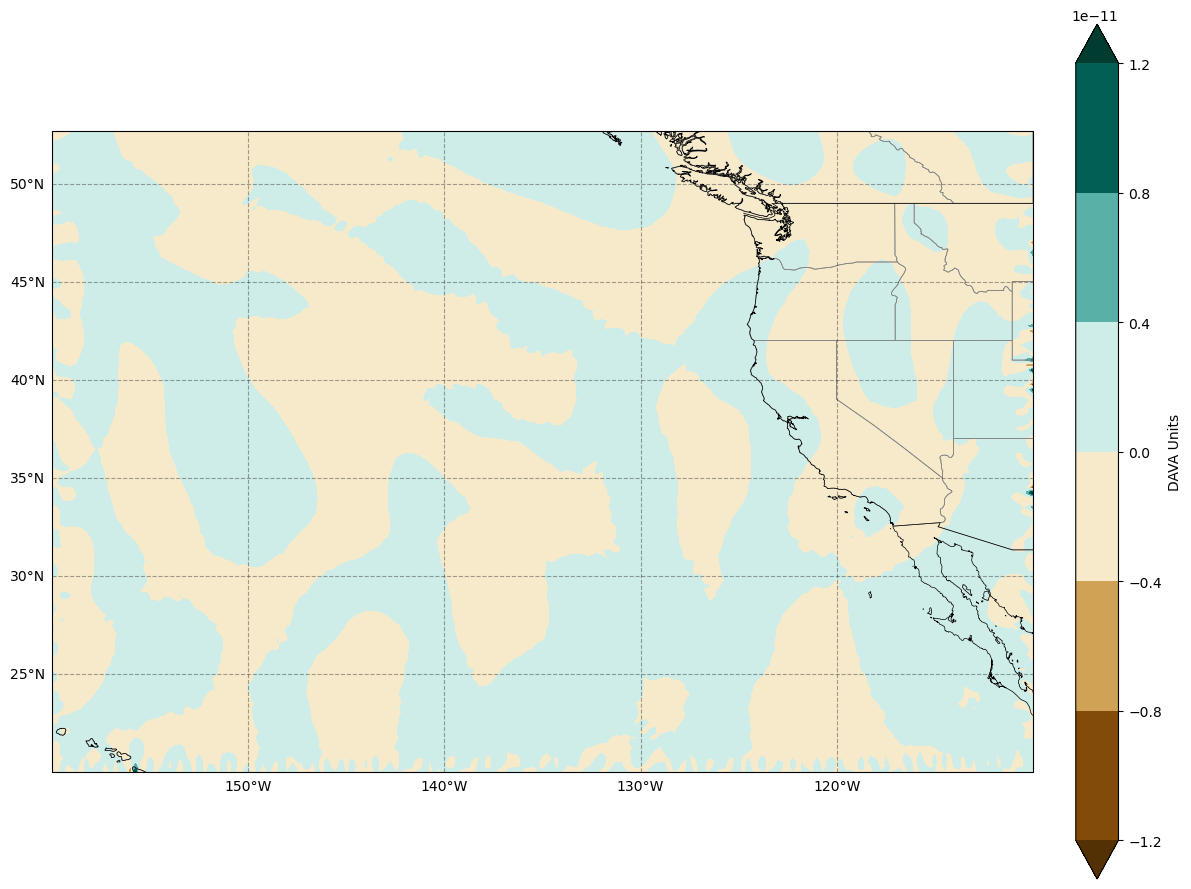

In [25]:
# Smoothing the geopotential height field (z_sliced)
n_reps = 80
z_smooth = xr.apply_ufunc(mpcalc.smooth_n_point, z_sliced, 9, n_reps, dask='parallelized',
                          output_dtypes=[z_sliced.dtype])

# Selecting smoothed geopotential height at 500 and 900 hPa levels
z_500_smooth = z_smooth.sel(level=500)
z_900_smooth = z_smooth.sel(level=900)

# Compute geostrophic wind components using the smoothed geopotential height at 500 hPa and 900 hPa levels
u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500_smooth) * units.meter / units.second
V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900_smooth) * units.meter / units.second
V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)

# Compute geostrophic wind components using the smoothed geopotential height
u_g_raw, v_g_raw = mpcalc.geostrophic_wind(z_smooth) * units.meter / units.second

# Convert the raw geostrophic wind output (Pint Quantities) back to xarray DataArray
# This step ensures that the coordinates (level, lat, lon) are retained
u_g = xr.DataArray(u_g_raw.magnitude, coords=z_smooth.coords, dims=z_smooth.dims, attrs={'units': 'm/s'})
v_g = xr.DataArray(v_g_raw.magnitude, coords=z_smooth.coords, dims=z_smooth.dims, attrs={'units': 'm/s'})

# Calculate absolute vorticity and select the 500 and 700 hPa levels
absolute_vorticity = mpcalc.absolute_vorticity(u_g, v_g)
absolute_vorticity_900 = absolute_vorticity.sel(level=900)
absolute_vorticity_500 = absolute_vorticity.sel(level=500)

abs_vort_adv = mpcalc.advection(absolute_vorticity, u_g, v_g)

abs_vort_adv_500 = abs_vort_adv.sel(level=500)
abs_vort_adv_900 = abs_vort_adv.sel(level=900)

differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
#plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
cf = plt.contourf(differential_abs_vorticity_advection['longitude'], differential_abs_vorticity_advection['latitude'], differential_abs_vorticity_advection, cmap=plt.cm.BrBG, extend='both')
plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

# Add the title, set the map extent, and add map features
#plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.tight_layout()
plt.show()


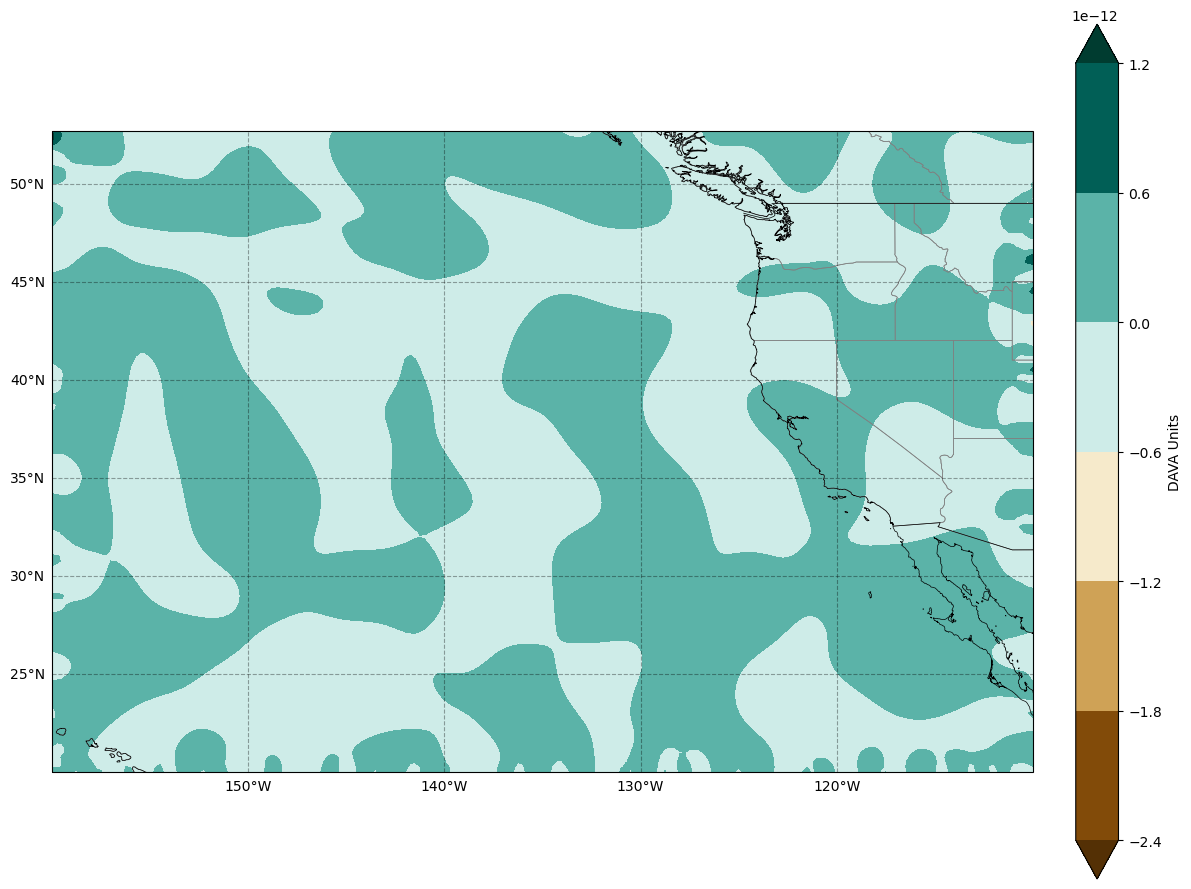

In [29]:
# Smoothing the geopotential height field (z_sliced)
n_reps = 80
u_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, u_sliced, 9, n_reps, dask='parallelized',
                          output_dtypes=[u_sliced.dtype])
v_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, v_sliced, 9, n_reps, dask='parallelized',
                          output_dtypes=[v_sliced.dtype])
z_smooth_raw = xr.apply_ufunc(mpcalc.smooth_n_point, z_sliced, 9, n_reps, dask='parallelized',
                          output_dtypes=[z_sliced.dtype])

# Selecting smoothed geopotential height at 500 and 900 hPa levels
z_500_smooth = z_smooth.sel(level=500)
z_900_smooth = z_smooth.sel(level=900)

# Convert the raw geostrophic wind output (Pint Quantities) back to xarray DataArray
# This step ensures that the coordinates (level, lat, lon) are retained
u = xr.DataArray(u_smooth_raw, coords=u_smooth_raw.coords, dims=u_smooth_raw.dims) * units('m/s')
v = xr.DataArray(v_smooth_raw, coords=v_smooth_raw.coords, dims=v_smooth_raw.dims) * units('m/s')

# Calculate absolute vorticity and select the 500 and 700 hPa levels
absolute_vorticity = mpcalc.absolute_vorticity(u, v)
absolute_vorticity_900 = absolute_vorticity.sel(level=900)
absolute_vorticity_500 = absolute_vorticity.sel(level=500)

abs_vort_adv = mpcalc.advection(absolute_vorticity, u, v)

abs_vort_adv_500 = abs_vort_adv.sel(level=500)
abs_vort_adv_900 = abs_vort_adv.sel(level=900)

differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

#isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
#plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
cf = plt.contourf(differential_abs_vorticity_advection['longitude'], differential_abs_vorticity_advection['latitude'], differential_abs_vorticity_advection, cmap=plt.cm.BrBG, extend='both')
plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

# Add the title, set the map extent, and add map features
#plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.tight_layout()
plt.show()


In [30]:
differential_abs_vorticity_advection

Magnitude,[[-2.675473050083133e-12 -9.272950679670577e-13 -2.7007856348680186e-13 ... 1.646517319409503e-13 7.03642013105451e-15 -2.5139772321417817e-13] [-9.962185848541083e-13 -2.483133733830184e-13 2.1935554549585803e-14 ... 1.224661687966387e-13 2.332160591217939e-14 -1.1968441808672356e-13] [6.464525881639094e-13 5.497407852613419e-13 4.0656886010345845e-13 ... 1.4936703233381989e-13 1.3352560803846806e-13 1.217514813157029e-13] ... [6.974569594804663e-16 -6.4680709195268744e-15 -1.564112959934869e-16 ... 1.929524211904916e-15 1.3466830936981155e-14 3.749423506365304e-14] [-2.25970219409494e-14 -1.459687078584667e-14 3.935948606448572e-15 ... -3.764846083934083e-14 -3.91582086625812e-14 -1.0438248947394625e-14] [1.8163469363707605e-13 1.152545200182468e-13 7.613831419926014e-14 ... -9.114020786232455e-14 -1.3221468573285532e-13 -9.927730989411338e-14]]
Units,meter/kilogram


In [ ]:
time = ds_pl_sliced.time.values
int_datetime_index = pd.DatetimeIndex([time])

# Calculate absolute vorticity and select the 500 and 700 hPa levels
absolute_vorticity = mpcalc.absolute_vorticity(u_g_s_da, v_g_s_da)
absolute_vorticity_900 = absolute_vorticity.sel(level=900)
absolute_vorticity_500 = absolute_vorticity.sel(level=500)

abs_vort_adv = mpcalc.advection(absolute_vorticity, u_g_s_da, v_g_s_da)

abs_vort_adv_500 = abs_vort_adv.sel(level=500)
abs_vort_adv_900 = abs_vort_adv.sel(level=900)

differential_abs_vorticity_advection = (abs_vort_adv_900 - abs_vort_adv_500) / (400 * units('hPa')).to_base_units()

# Smoothing the differential vorticity advection
differential_abs_vorticity_advection_smoothed = gaussian_filter(differential_abs_vorticity_advection, sigma=5)
z_500_smoothed = gaussian_filter(z_500, sigma=3)
z_900_smoothed = gaussian_filter(z_900, sigma=3)

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})


isohypses = plt.contour(z_500['longitude'], z_500['latitude'], z_500_smoothed, colors='black', levels=np.arange(5000, 6200, 60), linewidths=0.5)
plt.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
cf = plt.contourf(differential_abs_vorticity_advection['longitude'], differential_abs_vorticity_advection['latitude'], differential_abs_vorticity_advection_smoothed, cmap=plt.cm.BrBG, extend='both')
plt.colorbar(cf, orientation='vertical', label='DAVA Units', fraction=0.046, pad=0.04)

# Add the title, set the map extent, and add map features
plt.title(f'ERA5 Reanalysis Differential Absolute Vorticity Advection and 500-hPa Geopotential Height | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.tight_layout()
plt.show()

In [19]:
ds_pl_sliced = ds_pl.isel(time=0)

# Slice the dataset to get the data for the region of interest
ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

# Slice the dataset to get the data for the pressure levels at 850 hPa
t_sliced = ds_pl_sliced['T'].sel(level=slice(500, 900)) # units: K
u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 900)) # units: m/s
v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 900)) # units: m/s
z_sliced = ds_pl_sliced['Z'].sel(level=slice(500, 900)) / g # units: m
q_sliced = ds_pl_sliced['Q'].sel(level=900) * 1000 # units: g/kg

# Selecting
z_500 = z_sliced.sel(level=500)
z_900 = z_sliced.sel(level=900)
u_g_500, v_g_500 = mpcalc.geostrophic_wind(z_500) * units.meter / units.second
V_g_500 = mpcalc.wind_speed(u_g_500, v_g_500)
u_g_900, v_g_900 = mpcalc.geostrophic_wind(z_900) * units.meter / units.second
V_g_900 = mpcalc.wind_speed(u_g_900, v_g_900)
u_g, v_g = mpcalc.geostrophic_wind(z_sliced) * units.meter / units.second

# MetPy smoothing
n_reps = 80
u_g_s = mpcalc.smooth_n_point(u_g, 9, n_reps)
v_g_s = mpcalc.smooth_n_point(v_g, 9, n_reps)

In [14]:
lats = ds_pl_sliced['latitude'].metpy.unit_array
lons = ds_pl_sliced['longitude'].metpy.unit_array

# Calculate distance between grid points
# will need for computations later
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

In [18]:
avor_900 = mpcalc.absolute_vorticity(u_g_s, v_g_s, dx, dy)
#avor_500 = mpcalc.absolute_vorticity(uwnd_500s, vwnd_500s, dx, dy, lats)

TypeError: bad operand type for abs(): 'NoneType'

In [12]:
u_g_s_da = xr.DataArray(u_g_s, dims=['latitude', 'longitude', 'level'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude'], 'level': u_sliced['level']})


ValueError: conflicting sizes for dimension 'latitude': length 12 on the data but length 141 on coordinate 'latitude'

In [11]:
v_g_s

array([[[ 2.85054883e+01,  2.87660412e+01,  2.85706266e+01, ...,
         -1.41876059e+01, -1.37942713e+01, -1.31378784e+01],
        [ 2.79596619e+01,  2.80682803e+01,  2.78258180e+01, ...,
         -1.28037177e+01, -1.24774804e+01, -1.18619396e+01],
        [ 2.78114768e+01,  2.76962889e+01,  2.74294559e+01, ...,
         -1.17207436e+01, -1.13919628e+01, -1.09794267e+01],
        ...,
        [-4.22238413e+00, -3.47554290e+00, -2.98170870e+00, ...,
          6.48283176e+00,  7.53559969e+00,  9.38307584e+00],
        [-3.60262481e+00, -3.13876769e+00, -2.40445011e+00, ...,
          6.10903891e+00,  7.03632740e+00,  8.52718050e+00],
        [-3.64182355e+00, -3.25654247e+00, -1.34114510e+00, ...,
          5.36091104e+00,  5.84159505e+00,  7.18457482e+00]],

       [[ 2.79843826e+01,  2.87660412e+01,  2.87009030e+01, ...,
         -1.41863533e+01, -1.39909386e+01, -1.37278804e+01],
        [ 2.71766915e+01,  2.76295595e+01,  2.76014619e+01, ...,
         -1.30412954e+01, -1.28682034e+01, -1.25100443e+01],
        [ 2.67084298e+01,  2.70216200e+01,  2.70208819e+01, ...,
         -1.21155640e+01, -1.18698235e+01, -1.15645646e+01],
        ...,
        [ 2.72504655e+00,  1.19985639e+00,  1.83178143e-01, ...,
          6.75217910e+00,  7.82396917e+00,  9.66348960e+00],
        [ 1.61428098e+00,  5.88839328e-01, -2.03525846e-02, ...,
          6.56802611e+00,  7.45295450e+00,  8.90487504e+00],
        [ 1.83467180e-03, -7.65058146e-01,  9.54029343e-02, ...,
          6.12780386e+00,  6.51125027e+00,  7.27814308e+00]],

       [[ 2.76561861e+01,  2.77864626e+01,  2.72628515e+01, ...,
         -1.39258004e+01, -1.38600358e+01, -1.35982303e+01],
        [ 2.73739950e+01,  2.71267605e+01,  2.66520625e+01, ...,
         -1.31158597e+01, -1.31385604e+01, -1.31007062e+01],
        [ 2.70981067e+01,  2.67446681e+01,  2.63799000e+01, ...,
         -1.24455167e+01, -1.24348033e+01, -1.26694791e+01],
        ...,
        [ 2.81312523e+00,  1.13231973e+00,  1.59968659e-01, ...,
          6.48761003e+00,  7.39142519e+00,  9.00379825e+00],
        [ 1.23295476e+00,  1.05233333e-01, -3.93898168e-01, ...,
          6.37281239e+00,  7.03395671e+00,  8.34559659e+00],
        [-1.15217390e+00, -1.91539737e+00, -6.69655212e-01, ...,
          6.03240092e+00,  6.03240092e+00,  6.60481853e+00]],

       ...,

       [[ 2.73602456e+01,  2.70339282e+01,  2.57919177e+01, ...,
         -1.22585124e+01, -1.24874357e+01, -1.27486149e+01],
        [ 2.75029291e+01,  2.62858028e+01,  2.52640119e+01, ...,
         -1.19693402e+01, -1.20347009e+01, -1.15684818e+01],
        [ 2.63803791e+01,  2.56519017e+01,  2.49781352e+01, ...,
         -1.17364519e+01, -1.18475414e+01, -1.19234284e+01],
        ...,
        [ 1.97098518e+00,  1.39723132e+00,  1.22132704e+00, ...,
          5.19765623e-01,  1.11256229e+00,  2.43879083e+00],
        [ 1.32737840e+00,  1.16624263e+00,  1.43237986e+00, ...,
          1.07658099e-01,  6.02111790e-01,  2.03782545e+00],
        [ 4.72427992e-02,  1.43563069e-01,  2.15436338e+00, ...,
         -1.00585882e+00, -8.61837084e-01,  4.80225347e-01]],

       [[ 2.60205278e+01,  2.61514306e+01,  2.52686197e+01, ...,
         -1.17355277e+01, -1.19315687e+01, -1.19967069e+01],
        [ 2.56788078e+01,  2.51391467e+01,  2.45315154e+01, ...,
         -1.13785397e+01, -1.13389734e+01, -1.04608346e+01],
        [ 2.45284801e+01,  2.44647015e+01,  2.41867700e+01, ...,
         -1.11683967e+01, -1.12052378e+01, -1.12085020e+01],
        ...,
        [ 1.40791076e+00,  9.61322991e-01,  8.22775073e-01, ...,
         -4.40000764e-01,  1.39248016e-01,  1.54721888e+00],
        [ 7.11808935e-01,  8.56374497e-01,  1.15195512e+00, ...,
         -7.19220566e-01, -7.09615212e-01, -6.16931341e-01],
        [-4.78390675e-01,  2.87584807e-01,  2.29792645e+00, ...,
         -9.57698687e-01, -1.86723724e+00, -2.53780979e+00]],

       [[ 2.49745582e+01,  2.49745582e+01,  2.38958630e+01, ...,
         -1.10490710e+01, -1.11142092e+01, -1.09826801e+01],
      

In [ ]:
v_g_s